# Illustration figures used in the manuscript

In [61]:
# math
import numpy as np
from numpy.random import multivariate_normal as mvn
from scipy.stats import ortho_group, uniform, bernoulli
from scipy.linalg import sqrtm, cholesky, cho_factor, cho_solve
from scipy.optimize import minimize

# plotting/visualization
import matplotlib.pyplot as plt
from cycler import cycler

# python utils
from functools import partial

In [62]:
# use Cholesky decomposition to obtain the inverse
# gpt's solution
def cho_inv(A, dim):
    factor = cho_factor(A)
    return cho_solve(factor, np.eye(dim))

## Utils

### Matrix utils

#### Generate random matrices

In [63]:
def gen_matrix_with_eigs(eigs):
    """
    Generates a symmetric matrix with eigenvalues `eigs`.
    """
    dim = len(eigs)
    x = ortho_group.rvs(dim)
    return x.T @ np.diag(eigs) @ x

def gen_matrix_with_eigbounds(low, high, dim: int):
    """
    Generates a symmetric matrix with eigenvalues within [low, high].
    """
    eigs = low + (high - low) * uniform.rvs(size=dim)
    return gen_matrix_with_eigs(eigs)

#### Clip matrix

In [64]:
def clip_matrix(M: np.array, upper):
    """
    Assuming that M is PSD, return the matrix obtained by clipping the singular values at upper.
    """
    eigs = np.linalg.eig(M)
    return eigs[1] @ np.diag(np.minimum(eigs[0], upper)) @ eigs[1].T

### Distance measures

#### Wasserstein

In [65]:
def wasserstein_dist(mu_0, mu_1, Sigma_0, Sigma_1):
    """
    Return the squared W2 distance between N(mu_0, Sigma_0), N(mu_1, Sigma_1).
    """
    half_0 = sqrtm(Sigma_0)
    half_1 = sqrtm(Sigma_1)
    return np.sum((mu_0 - mu_1) ** 2) + np.sum((half_0 - half_1) ** 2)

#### Entropy, KL between Gaussians

In [66]:
def H(mu, Sigma):
    """
    Return the negentropy of N(mu, Sigma).
    """
    d = len(mu)
    assert d == Sigma.shape[0] and d == Sigma.shape[1]
    return -(
        d/2 * (1 + np.log(2 * np.pi))
        + 1/2 * np.log(np.linalg.det(Sigma))
    )

def kl_divergence(mu_0, mu_1, Sigma_0, Sigma_1):
    """
    Return the KL divergence
    KL( N(mu_0, Sigma_0) || N(mu_1, Sigma_1) ).
    """
    d = mu_0.shape[0]

    det_0 = np.linalg.det(Sigma_0)
    det_1 = np.linalg.det(Sigma_1)
    Sigma_1_inv = cho_inv(Sigma_1, d)
    div = np.log(det_1) - np.log(det_0)
    div -= d
    div += (Sigma_1_inv * Sigma_0).sum()
    div += (mu_1 - mu_0).T @ Sigma_1_inv @ (mu_1 - mu_0)
    div /= 2
    return div

### Misc

In [67]:
def softmax(x):
    """
    Univariate softmax function.
    """
    return np.exp(x) / (1 + np.exp(x))

In [68]:
class Experiment():
    """
    Parent class for experiments.
    Implements BWGD and FBGVI and plots results.
    """

    def __init__(
        self,
        log_potential,
        gradient_oracle,
        dist_objective,
        dim = 5, beta = 1,
        grad_V = None,
        hess_V = None,
    ):
        """
        Initialize parameters of experiment:
        - params: dim, beta
        - log_potential
            * takes in a vector x and produces the unnormalized log potential.
        - dist_objective
            * (mu, Sigma) -> objective function to plot
            * by default, we can make this equal to EE_p V - H(p)
        - gradient_oracle
            * (mu, Sigma) -> estimate for (EE nabla V, EE nabla^2 V)
            * default:
                > draw x ~ N(mu, Sigma)
                > compute v = V(x)
                > v.backward()
                > x.grad
        - initialize Sigma_0 at isotropic Gaussian
        """

        self.log_potential = log_potential
        self.gradient_oracle = gradient_oracle
        self.dist_objective = dist_objective
        self.dim = dim
        self.grad_V = grad_V
        self.hess_V = hess_V

        # initialize mean with all zeros
        self.init_mu = np.zeros(dim)

        # initialize Sigma at identity
        self.init_Sigma = np.eye(dim) / beta

    def laplace_approx(self):
        """
        Compute Laplace approximation to target distribution.
        """
        if self.hess_V is None:
            raise NotImplementedError

        x0 = np.zeros(self.dim)

        # compute MAP
        result = minimize(
            self.log_potential,
            x0,
            jac = self.grad_V,
            hess = self.hess_V
        )
        mu = result.x

        # compute Hessian at map
        H = self.hess_V(mu)

        # compute inverse of Hessian to obtain Sigma
        Sigma = cho_inv(H, self.dim)

        return mu, Sigma

    def run_iter(self, alg, eta, mu, Sigma):
        """
        Run an iteration of the specified algorithm to update (mu, Sigma).
        Returns new (mu, Sigma).
        """

        # if alg == "bwgd":
        #     hat_nabla1, hat_nabla2 = self.gradient_oracle(mu, Sigma)  # hat_nabla1 is b_k, hat_nabla2 is S_k

        #     # compute gradient in mu
        #     # (update is the same between BWGD and FBGVI)
        #     # grad_mu = self.Sigma_true_inv @ (mu - self.mu_true)
        #     mu = mu - eta * hat_nabla1
        #     # compute gradient in Sigma
        #     M = np.eye(self.dim) - eta * (hat_nabla2 - cho_inv(Sigma))
        #     Sigma = M @ Sigma @ M

        #     return mu, Sigma

        if alg == "fbgvi":
            hat_nabla1, hat_nabla2 = self.gradient_oracle(mu, Sigma)  # hat_nabla1 is b_k, hat_nabla2 is S_k

            # compute gradient in mu
            # (update is the same between BWGD and FBGVI)
            # grad_mu = self.Sigma_true_inv @ (mu - self.mu_true)
            mu = mu - eta * hat_nabla1
            # do forward step for the energy
            M_half = np.eye(self.dim) - eta * hat_nabla2
            Sigma_half = M_half @ Sigma @ M_half

            # do backward step for the entropy
            sqrt_matrix = sqrtm(
                Sigma_half @ (Sigma_half + 4 * eta * np.eye(self.dim))
            )
            sqrt_matrix = np.real(sqrt_matrix)
            Sigma = 0.5 * (Sigma_half + 2 * eta * np.eye(self.dim) + sqrt_matrix)

            return mu, Sigma
        elif alg == "bwgd":
            hat_nabla1, hat_nabla2 = self.gradient_oracle(
                mu, Sigma
            )  # hat_nabla1 is b_k, hat_nabla2 is S_k

            # compute gradient in mu
            # (update is the same between BWGD and FBGVI)
            # grad_mu = self.Sigma_true_inv @ (mu - self.mu_true)
            mu = mu - eta * hat_nabla1
            # compute gradient in Sigma
            M = np.eye(self.dim) - eta * (hat_nabla2 - cho_inv(Sigma, self.dim))
            Sigma = M @ Sigma @ M

            return mu, Sigma

        else:
            raise NotImplementedError


    def run_experiment(
        self,
        iters_list = 10000, time = 10000,
        init_mu = None, init_Sigma = None,
        return_VI = False,
        alg="fbgvi"
    ):
        """
        Run only FBGVI
        """
        if init_mu is None:
            init_mu = self.init_mu
        if init_Sigma is None:
            init_Sigma = self.init_Sigma

        for iters in iters_list:
            eta = time / iters
            #gd_mu_k, gd_Sigma_k = init_mu, init_Sigma
            prox_mu_k, prox_Sigma_k = init_mu, init_Sigma
            #aprox_mu_k, aprox_Sigma_k = init_mu, init_Sigma
            #aprox_mu_qkk, aprox_Sigma_qkk = init_mu, init_Sigma
            #tk = 1

            # gd_dists = [self.dist_objective(gd_mu_k, gd_Sigma_k)]
            VI_mu = [prox_mu_k]
            VI_Sigma = [prox_Sigma_k]
            prox_dists = [self.dist_objective(prox_mu_k, prox_Sigma_k)]
            # aprox_dists = [self.dist_objective(aprox_mu_k, aprox_Sigma_k)]

            for k in range(iters):
                new_mu, new_Sigma = self.run_iter(alg, eta, prox_mu_k, prox_Sigma_k)
                prox_mu_k, prox_Sigma_k = new_mu, new_Sigma
                prox_dists.append(self.dist_objective(prox_mu_k, prox_Sigma_k))
                VI_mu.append(prox_mu_k)
                VI_Sigma.append(prox_Sigma_k)


            if return_VI:
                return np.linspace(0, time, iters+1), prox_dists, VI_mu, VI_Sigma
            else:
                return np.linspace(0, time, iters+1), prox_dists


# plot as a seperate function

def plot_results(time_axes, alg_dists, ax = None,
):
    """
    Plot distances and label results for all the algorithms of interest.
    """

    # configure plot

    #plt.title(fr"{self.dist_objective_name} over iterations")
    plt.xlabel(r"time elapsed ($\eta \times \# $iters)")
    #plt.ylabel(self.dist_objective_name)

    fig = plt.gcf()
    fig.set_size_inches(8, 5)
    fig.set_dpi(160)

    if ax is None:
        ax = plt.gca()
    ax.set_prop_cycle(
        cycler('color', list(plt.rcParams["axes.prop_cycle"].by_key()["color"])) *
        cycler('linestyle', ['-', '--'])
    )

    for time, (alg_name, dists) in zip(time_axes, alg_dists):
        """
        Plot distances and label results for particular algorithm of interest.
        """
        dists = np.array(dists)
        ax.plot(time, dists, label = alg_name, linewidth=0.8)

    plt.legend()
    plt.show()

In [69]:
class GaussianExperimentEstimator(Experiment):
    """
    Run convergence experiment for different algorithms on randomly generated target.
    """

    def __init__(
        self, dim = 5, alpha = 0.01, beta = 1,
        estimator = "G",
        W2 = False,
        mu_true = None,
        Sigma_true = None,
        seed = 0
    ):
        """
        Initialize parameters of experiment:
        - dim, alpha
        - true (mu, Sigma) and precomputed Sigma^{-1}
        - nabla V(x)
        - initial Sigma for experiments
        """

        """
        define potential
        V = 1/2 (x - mu) Sigma^-1 (x - mu)
        """
        if seed is not None:
            np.random.seed(seed)

        def log_potential(x, mu, Sigma_inv):
            assert x.shape[0] == mu.shape[0]
            first = x.T - mu
            second = np.dot(Sigma_inv, (x.T - mu).T)
            return 1/2 * np.dot(
                first,
                second
            )

        if mu_true is None:
            mu_true = uniform.rvs(size = (dim, ))
        if Sigma_true is None:
            Sigma_true = gen_matrix_with_eigs(
                np.geomspace(1/beta, 1/alpha, dim)
            )
        
        self.mu_true = mu_true
        self.Sigma_true = Sigma_true

        Sigma_true_inv = cho_inv(Sigma_true, dim)

        log_potential_pure = partial(
            log_potential, mu = mu_true, Sigma_inv = Sigma_true_inv
        )

        if estimator == "G":
            def gradient_oracle(mu, Sigma):
                nabla_1 = Sigma_true_inv @ (mu - mu_true)
                nabla_2 = Sigma_true_inv
                return nabla_1, nabla_2
        elif estimator == "SG":
            def gradient_oracle(mu, Sigma):

                # x = mvn(mu, Sigma)
                factor = cholesky(Sigma, lower=True)
                x = mu + (factor @ np.random.randn(dim, 1)).squeeze()

                nabla_1 = Sigma_true_inv @ (x - mu_true)
                nabla_2 = Sigma_true_inv
                return nabla_1, nabla_2
        elif estimator == "SVRG":
            def gradient_oracle(mu, Sigma):  # now it is variance-reduction
                c = 0.9

                # x = mvn(mu, Sigma)
                factor, lower = cho_factor(Sigma, lower=True)
                x = mu + (np.tril(factor) @ np.random.randn(dim, 1)).squeeze()

                nabla_1 = Sigma_true_inv @ (x - mu_true) - c * cho_solve((factor, lower), x - mu)
                nabla_2 = Sigma_true_inv
                return nabla_1, nabla_2
        else:
            raise NotImplemented

        if W2:
            # distance objective is the W2 distance
            def dist_objective(mu, Sigma):
                return np.log(wasserstein_dist(mu, mu_true, Sigma, Sigma_true))
        else:
            # distance objective is the KL divergence to target
            def dist_objective(mu, Sigma):
                return np.log(kl_divergence(mu, mu_true, Sigma, Sigma_true))

        super().__init__(
            log_potential_pure,
            gradient_oracle,
            dist_objective,
            dim = dim
        )

In [70]:
seed = 40
dim = 50
alpha_choice = 2 * 5e-3
#time = 600
time = 600
iters = 600

np.random.seed(seed=seed)
alpha_choice_init = 0.1
init_mu = uniform.rvs(size = (dim, )) - 15* np.ones(dim)
init_Sigma = gen_matrix_with_eigs(
                np.geomspace(1, 1/alpha_choice_init, dim)[::-1]
            )


exp_SG = GaussianExperimentEstimator(dim = dim, alpha = alpha_choice, estimator = "SG", seed=seed)
exp_BWGD = GaussianExperimentEstimator(dim = dim, alpha = alpha_choice, estimator = "SG", seed=seed)
exp_SVRG = GaussianExperimentEstimator(dim = dim, alpha = alpha_choice, estimator = "SVRG", seed=seed)
#exp.run_experiment(iters_list = [360, 400, 6400], time = 400)
iter_SG, log_KL_SG, VI_mu_SG, VI_Sigma_SG = exp_SG.run_experiment(alg="fbgvi", iters_list = [iters], time = time, return_VI=True, init_mu = init_mu, init_Sigma=init_Sigma)
iter_BWGD, log_KL_BWGD, VI_mu_BWGD, VI_Sigma_BWGD = exp_BWGD.run_experiment(alg="bwgd", iters_list = [iters], time = time, return_VI=True, init_mu = init_mu, init_Sigma=init_Sigma)
iter_SVRG, log_KL_SVRG, VI_mu_SVRG, VI_Sigma_SVRG = exp_SVRG.run_experiment(alg="fbgvi", iters_list = [iters], time = time, return_VI=True, init_mu = init_mu, init_Sigma=init_Sigma)

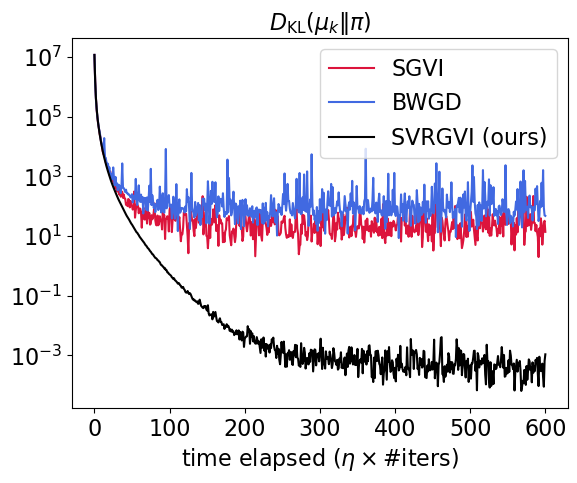

In [71]:
plt.figure()
KL_SG = [10 ** i for i in log_KL_SG]
KL_BWGD = [10 ** i for i in log_KL_BWGD]
KL_SVRG = [10 ** i for i in log_KL_SVRG]
# plt.plot(iter_G, log_KL_G, label="Gradient")
plt.plot(iter_SG, KL_SG, label="SGVI", color="crimson",)
plt.plot(iter_BWGD, KL_BWGD, label="BWGD", color="royalblue")
plt.plot(iter_SVRG, KL_SVRG, label="SVRGVI (ours)", color="black")
plt.title(r"$D_{\mathsf{KL}}(\mu_k \Vert {\pi})$", fontsize=16)
plt.xlabel(r"time elapsed ($\eta \times \# $iters)", fontsize=16)
plt.yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.savefig('loss.pdf',format='pdf', bbox_inches="tight")

### BW geometry

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_gaussian_contour(mean, cov, ax=None, n_std=1.0, **kwargs):
    """
    Plot a 2D Gaussian distribution as an ellipse centered at mean with covariance matrix cov.
    
    Parameters:
    - mean: 2D vector, mean of the Gaussian.
    - cov: 2x2 covariance matrix.
    - ax: Matplotlib Axes object. If None, a new plot is created.
    - n_std: Number of standard deviations for the ellipse size.
    - kwargs: Additional arguments passed to the Ellipse patch (e.g., color, alpha).
    """
    if ax is None:
        ax = plt.gca()
    
    # Eigen decomposition of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # Compute the angle of the ellipse (in degrees)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 1]))
    
    # Width and height of the ellipse
    width, height = 2 * n_std * np.sqrt(eigenvalues)
    
    # Create the Ellipse patch
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)
    
    # Add the Ellipse to the plot
    ax.add_patch(ellipse)
    return ax


In [73]:
## Get marginals of the first two componennt

A = np.zeros(shape=(2,dim))
A[0,0] = 1
A[1,1] = 1

VI_mu_SG_2 = []
VI_mu_BWGD_2 = []
VI_mu_SVRG_2 = []

VI_Sigma_SG_2 = []
VI_Sigma_BWGD_2 = []
VI_Sigma_SVRG_2 = []

for i in range(len(VI_mu_SVRG)):
    VI_mu_SG_2.append(np.squeeze(A @ VI_mu_SG[i][:, None]))
    VI_mu_BWGD_2.append(np.squeeze(A @ VI_mu_BWGD[i][:, None]))
    VI_mu_SVRG_2.append(np.squeeze(A @ VI_mu_SVRG[i][:, None]))
    VI_Sigma_SG_2.append(A @ VI_Sigma_SG[i] @ A.T)
    VI_Sigma_BWGD_2.append(A @ VI_Sigma_BWGD[i] @ A.T)
    VI_Sigma_SVRG_2.append(A @ VI_Sigma_SVRG[i] @ A.T)

mu_true = exp_SG.mu_true
Sigma_true = exp_SG.Sigma_true

mu_true_2 = np.squeeze(A @ mu_true[:, None])
Sigma_true_2 = A @ Sigma_true @ A.T


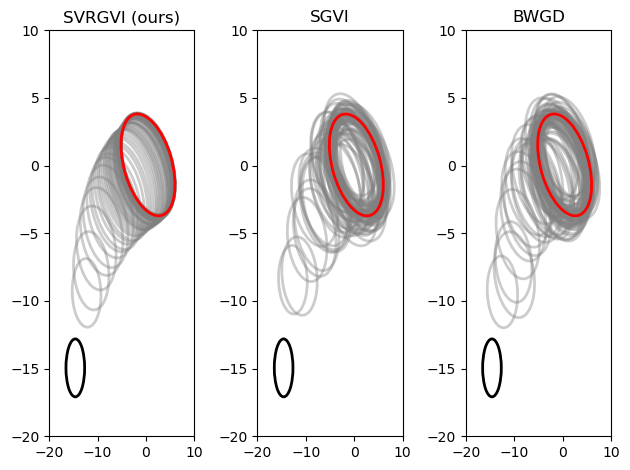

In [74]:
x_up = 10
x_low = -20
y_up = 10
y_low = -20
step = 8
i_low = 0

fig, axs = plt.subplots(1, 3)
for i in range(i_low, len(VI_mu_SVRG), step):
    if i == 0:
        color = 'black'
        alpha = 1.0
    else:
        color = 'grey'
        alpha = 0.4
    plot_gaussian_contour(VI_mu_SVRG_2[i], VI_Sigma_SVRG_2[i], ax=axs[0], n_std=1.0, edgecolor=color, facecolor='none', lw=2, alpha=alpha)
    axs[0].set_xlim(x_low, x_up)
    axs[0].set_ylim(y_low, y_up)
plot_gaussian_contour(mu_true_2, Sigma_true_2, ax=axs[0], n_std=1.0, edgecolor='red', facecolor='none', lw=2)

for i in range(i_low, len(VI_mu_SVRG), step):
    if i == 0:
        color = 'black'
        alpha = 1.0
    else:
        color = 'grey'
        alpha = 0.4
    plot_gaussian_contour(VI_mu_SG_2[i], VI_Sigma_SG_2[i], ax=axs[1], n_std=1.0, edgecolor=color, facecolor='none', lw=2, alpha=alpha)
    axs[1].set_xlim(x_low, x_up)
    axs[1].set_ylim(y_low, y_up)
plot_gaussian_contour(mu_true_2, Sigma_true_2, ax=axs[1], n_std=1.0, edgecolor='red', facecolor='none', lw=2)

for i in range(i_low, len(VI_mu_SVRG), step):
    if i == 0:
        color = 'black'
        alpha = 1.0
    else:
        color = 'grey'
        alpha = 0.4
    plot_gaussian_contour(VI_mu_BWGD_2[i], VI_Sigma_BWGD_2[i], ax=axs[2], n_std=1.0, edgecolor=color, facecolor='none', lw=2, alpha=alpha)
    axs[2].set_xlim(x_low, x_up)
    axs[2].set_ylim(y_low, y_up)
plot_gaussian_contour(mu_true_2, Sigma_true_2, ax=axs[2], n_std=1.0, edgecolor='red', facecolor='none', lw=2)



axs[0].set_title("SVRGVI (ours)")
axs[1].set_title("SGVI")
axs[2].set_title("BWGD")
plt.tight_layout()
plt.savefig('trajectories.pdf', format='pdf')

### Illustration

In [75]:
seed = 42
np.random.seed(seed=seed)
alpha = 0.01
beta = 1
# Target distribution params
mu_true = np.zeros(2)
Sigma_true = np.array([[1.0, 0],[0.0, 2.0]])
Sigma_true_inv = cho_inv(Sigma_true, 2)


# VI distribution params
epsilon = 0.01
mu = mu_true + epsilon * uniform.rvs(size = (2, ))
Sigma = Sigma_true + epsilon * gen_matrix_with_eigs(
            np.geomspace(1/beta, 1/alpha, 2)
        )

# True nabla
nabla_true = Sigma_true_inv @ (mu - mu_true)

n_sample = 1000
SGVI_samples = list()
SVRGVI_samples = list()
c = 0.9
for i in range(n_sample):
    # SGVI estimator
    factor = cholesky(Sigma, lower=True)
    x = mu + (factor @ np.random.randn(2, 1)).squeeze()
    nabla_sgvi = Sigma_true_inv @ (x - mu_true)
    SGVI_samples.append(nabla_sgvi)

for i in range(n_sample):
    factor, lower = cho_factor(Sigma, lower=True)
    x = mu + (np.tril(factor) @ np.random.randn(2, 1)).squeeze()
    nabla_svrgvi = Sigma_true_inv @ (x - mu_true) - c * cho_solve((factor, lower), x - mu)
    SVRGVI_samples.append(nabla_svrgvi)

SGVI_samples = np.array(SGVI_samples)
SVRGVI_samples = np.array(SVRGVI_samples)


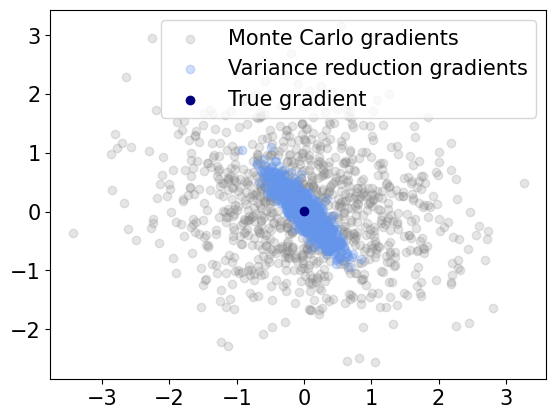

In [76]:
plt.scatter(SGVI_samples[:,0], SGVI_samples[:,1], label='Monte Carlo gradients', alpha=0.2, color = 'grey')
plt.scatter(SVRGVI_samples[:,0], SVRGVI_samples[:,1], label='Variance reduction gradients', alpha=0.3, color='cornflowerblue')
plt.scatter(nabla_true[0], nabla_true[1], label='True gradient', color='navy')
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('illustration.pdf', format='pdf')
plt.show()

In [77]:
seed = 42
np.random.seed(seed=seed)
alpha = 0.01
beta = 1
# Target distribution params
mu_true = np.zeros(2)
Sigma_true = np.array([[1.0, 0],[0.0, 2.0]])
Sigma_true_inv = cho_inv(Sigma_true, 2)


# VI distribution params
epsilon = 0.01
mu = mu_true + epsilon * uniform.rvs(size = (2, ))
Sigma = Sigma_true + epsilon * gen_matrix_with_eigs(
            np.geomspace(1/beta, 1/alpha, 2)
        )

# True nabla
nabla_true = Sigma_true_inv @ (mu - mu_true)

n_sample = 1000
cs = np.linspace(0,2,20)
vars = []
for c in cs:
    SVRGVI_samples = list()
    for i in range(n_sample):
        factor, lower = cho_factor(Sigma, lower=True)
        x = mu + (np.tril(factor) @ np.random.randn(2, 1)).squeeze()
        nabla_svrgvi = Sigma_true_inv @ (x - mu_true) - c * cho_solve((factor, lower), x - mu)
        SVRGVI_samples.append(nabla_svrgvi)
    SVRGVI_samples = np.array(SVRGVI_samples)
    SVRGVI_samples_mean = np.mean(SVRGVI_samples, axis=0)
    #print(SVRGVI_samples.shape)
    var = np.mean(np.sum((SVRGVI_samples - SVRGVI_samples_mean)**2, axis=1))
    vars.append(var)


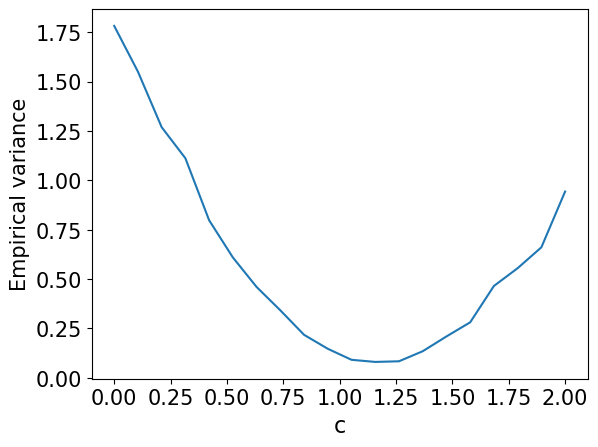

In [78]:
plt.plot(cs,vars)
plt.xlabel('c', fontsize=16)
plt.ylabel('Empirical variance', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('c_para.pdf', format='pdf') 